##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 自定义训练: 演示

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/customization/custom_training_walkthrough"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

本教程将向您展示如何使用自定义训练循环训练机器学习模型，以按物种对企鹅进行*分类*。在此笔记本中，您将使用 TensorFlow 完成以下任务：

1. 导入数据集
2. 构建简单的线性模型
3. 训练模型
4. 评估模型的有效性
5. 使用训练的模型进行预测

## TensorFlow 编程

本教程将演示以下 TensorFlow 编程任务：

- 使用 [TensorFlow Datasets API](https://tensorflow.google.cn/datasets/overview#load_a_dataset) 导入数据
- 使用 [Keras API](https://tensorflow.google.cn/guide/keras/) 构建模型和层


## 企鹅分类问题

设想您是一名鸟类学家，正在寻找一种能够对您发现的每只企鹅进行分类的自动化方法。机器学习提供了许多对企鹅进行统计分类的算法。例如，复杂的机器学习程序可以根据照片对企鹅进行分类。您在本教程中构建的模型会略微简单一些。它将根据企鹅的体重、鳍状肢长度和喙（特别是[嘴峰](https://en.wikipedia.org/wiki/Beak#Culmen)长度和宽度测量值）对企鹅进行分类。

企鹅共有 18 个种类，但在本教程中，您将仅尝试对以下三种进行分类：

- 帽带企鹅
- 金图企鹅
- 阿德利企鹅

<table>
  <tr><td>     <img src="https://tensorflow.google.cn/tutorials/customization/images/penguins_ds_species.png" alt="Illustration of Chinstrap, Gentoo, and Adélie penguins" class="no-filter">   </td></tr>
  <tr><td align="center">     <b>图 1</b>. <a href="https://en.wikipedia.org/wiki/Chinstrap_penguin">帽带</a>、<a href="https://en.wikipedia.org/wiki/Gentoo_penguin">金图</a>和<a href="https://en.wikipedia.org/wiki/Ad%C3%A9lie_penguin">阿德利</a>企鹅（作者 @allison_horst，CC BY-SA 2.0）。<br>
</td></tr>
</table>

幸运的是，有一支研究团队已经创建并共享了一个[含 334 只企鹅的数据集](https://allisonhorst.github.io/palmerpenguins/)，其中包含体重、鳍状肢长度、喙测量及其他数据。该数据集也可方便地用作[企鹅](https://tensorflow.google.cn/datasets/catalog/penguins) TensorFlow 数据集。 

## 安装

为企鹅数据集安装 `tfds-nightly` 软件包。`tfds-nightly` 软件包是 TensorFlow Datasets (TFDS) 的每日构建版。有关 TFDS 的更多信息，请参阅 [TensorFlow Datasets 概述](https://tensorflow.google.cn/datasets/overview)。

In [2]:
!pip install -q tfds-nightly

然后，从 Colab 菜单中选择 **Runtime &gt; Restart Runtime** 以重新启动 Colab 运行时。

请务必首先重新启动运行时，然后再继续本教程的其余步骤。

导入 TensorFlow 和其他所需 Python 模块。 

In [3]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)

TensorFlow version: 2.19.0
TensorFlow Datasets version:  4.9.9+nightly


## 导入数据集

默认的 [penguins/processed](https://tensorflow.google.cn/datasets/catalog/penguins) TensorFlow 数据集经清理、归一化并已准备就绪，可用于构建模型。在下载经处理的数据之前，请首先预览一个简化版本以熟悉原始企鹅调查数据。


### 预览数据

使用 TensorFlow Datasets [`tdfs.load`](https://tensorflow.google.cn/datasets/api_docs/python/tfds/load) 方法下载企鹅数据集的简化版本 (`penguins/simple`)。该数据集中有 344 条数据记录。将前五条记录提取到 [`DataFrame`](https://tensorflow.google.cn/datasets/api_docs/python/tfds/as_dataframe) 对象中，以检查此数据集中的样本值：

In [ ]:
ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

/opt/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Size...: 0 MiB [00:00, ? MiB/s]1/1 [00:00<00:00,  1.28 url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00,  1.27 url/s]
2025-07-11 18:06:01.517694: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-11 18:06:01.519467: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-11 18:06:01.519601: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Dataset penguins downloaded and prepared to /Users/bilibili/tensorflow_datasets/penguins/simple/1.0.0. Subsequent calls will reuse this data.
   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': float32,
    'culmen_depth_mm': float32,
    'culmen_length_mm': float32,
    'flipper_length_mm': float32,
    'island': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=int64, num_classes=3),
  

Dl Completed...: 100%|██████████| 1/1 [00:00<00:00,  1.11 url/s]

带编号的行是数据记录，每行一个*[样本](https://developers.google.com/machine-learning/glossary/#example)*，其中：

- 前六个字段是*[特征](https://developers.google.com/machine-learning/glossary/#feature)*：它们是样本的特点。在这里，这些字段包含了代表企鹅测量值的数字。
- 最后一列是*[标签](https://developers.google.com/machine-learning/glossary/#label)*：这是您要预测的值。对于此数据集，它是对应于企鹅物种名称的整数值（0、1 或 2）。

在数据集中，企鹅物种标签以数字表示，以便于在您所构建的模型中使用。这些数字对应于以下企鹅物种：

- `0`：阿德利企鹅
- `1`：帽带企鹅
- `2`：金图企鹅

依此顺序创建一个包含企鹅物种名称的列表。您将使用此列表来解释分类模型的输出：

In [5]:
class_names = ['Adélie', 'Chinstrap', 'Gentoo']

有关特征和标签的更多信息，请参阅[机器学习速成课程的“ML 术语”部分](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology)。

### 下载预处理数据集

现在，使用 `tfds.load` 方法下载预处理的企鹅数据集 (`penguins/processed`)，该方法会返回 `tf.data.Dataset` 对象的列表。请注意，`penguins/processed` 数据集不具备自己的测试集，因此请使用 80:20 拆分法[将完整数据集分割](https://tensorflow.google.cn/datasets/splits)成训练集和测试集。稍后您将使用测试数据集来验证您的模型。

In [6]:
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print("Train dataset sample: ")
print(df_train)

ds_train_batch = ds_train.batch(32)

Dl Size...: 0 MiB [00:00, ? MiB/s]0/1 [00:00<?, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00,  1.10 url/s]
                                                                

Dataset penguins downloaded and prepared to /Users/bilibili/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'features': Tensor(shape=(4,), dtype=float32),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})
Test dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2
Train dataset sample: 
                                         features  species
0  [0.49818182, 0.6904762, 0.42372882, 0.4027778]        0
1      [0.48, 0.071428575, 0.6440678, 0.44444445]        2
2    [0.7236364, 0.9047619, 0.6440678, 0.5833333]        1
3  [0.34545454, 0.5833333, 0.33898306, 0.3472222]        0
4       [0.10909091, 0.75, 

2025-07-11 18:06:03.254854: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-11 18:06:03.254945: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-11 18:06:03.271591: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

请注意，此版本的数据集已通过将数据减少到四个归一化特征和一个物种标签的方式进行了处理。在这种格式下，数据无需进一步处理即可快速用于训练模型。

In [7]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)

tf.Tensor(
[[0.49818182 0.6904762  0.42372882 0.4027778 ]
 [0.48       0.07142857 0.6440678  0.44444445]
 [0.7236364  0.9047619  0.6440678  0.5833333 ]
 [0.34545454 0.5833333  0.33898306 0.3472222 ]
 [0.10909091 0.75       0.3559322  0.41666666]
 [0.6690909  0.63095236 0.47457626 0.19444445]
 [0.8036364  0.9166667  0.4915254  0.44444445]
 [0.4909091  0.75       0.37288135 0.22916667]
 [0.33454546 0.85714287 0.37288135 0.2361111 ]
 [0.32       0.41666666 0.2542373  0.1388889 ]
 [0.41454545 0.5952381  0.5084746  0.19444445]
 [0.14909092 0.48809522 0.2542373  0.125     ]
 [0.23636363 0.4642857  0.27118644 0.05555556]
 [0.22181818 0.5952381  0.22033899 0.3472222 ]
 [0.24727273 0.5595238  0.15254237 0.25694445]
 [0.63272727 0.35714287 0.88135594 0.8194444 ]
 [0.47272727 0.15476191 0.6440678  0.4722222 ]
 [0.6036364  0.23809524 0.84745765 0.7361111 ]
 [0.26909092 0.5595238  0.27118644 0.16666667]
 [0.28       0.71428573 0.20338982 0.5416667 ]
 [0.10545454 0.5714286  0.33898306 0.2847222 ]
 [

2025-07-11 18:06:03.293409: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


您可以通过从批次中绘制一些特征来呈现一些聚类：

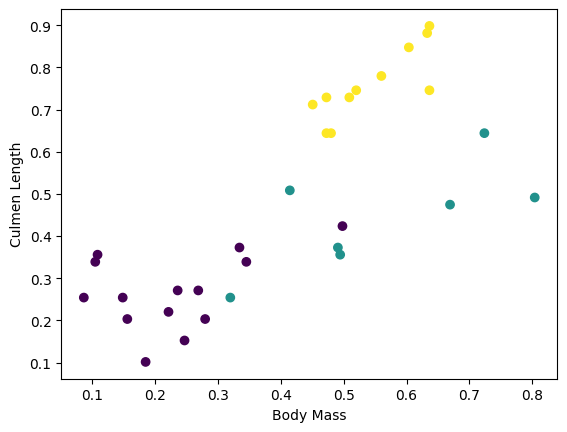

In [8]:
plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

## 构建简单的线性模型

### 为何要使用模型?

*[模型](https://developers.google.com/machine-learning/crash-course/glossary#model)*是特征与标签之间的关系。对于企鹅分类问题，模型定义了体重、鳍状肢和嘴峰测量值与预测的企鹅物种之间的关系。一些简单的模型可以用几行代数来描述，但复杂的机器学习模型具有大量难以概括的参数。

您能在*不*使用机器学习的情况下确定这四种特征与企鹅种类之间的关系吗？也就是说，您能使用传统的编程技术（例如，大量条件语句）来创建模型吗？也许可以，前提是您对数据集分析了足够长的时间，能够确定特定种类体重与嘴峰测量值之间的关系。但对于更加复杂的数据集，这种方法就会变得非常困难甚至不可能。好的机器学习方法*能够为您确定模型*。如果您将足够多的代表性样本馈送到正确的机器学习模型类型，程序将为您找出关系。

### 选择模型

我们需要选择要训练的模型种类。模型有许多类型，挑选一个好的模型需要经验。本教程使用神经网络来解决企鹅分类问题。神经网络可以找出特征与标签之间的复杂关系。它是一种高度结构化的计算图，分为一个或多个隐藏层。每个隐藏层由一个或多个神经元组成。神经网络有几种类别，此程序使用密集或全连接神经网络：一个层中的神经元从前一个层中的每一个神经元接收输入连接。例如，图 2 展示了一个密集神经网络，它由一个输入层、两个隐藏层和一个输出层组成。

<table>
  <tr><td>     <img src="https://tensorflow.google.cn/images/custom_estimators/full_network.png" alt="网络结构示意图: 输入层, 2 隐含层, 输出层">   </td></tr>
  <tr><td align="center">     <b>图 2.</b> 包含特征、隐藏层和预测的神经网络<br>{nbsp}   </td></tr>
</table>

对图 2 中的模型进行训练并向其馈送无标签样本后，它会产生三个预测值：这只企鹅是给定企鹅物种的可能性。这种预测称为[*推断*](https://developers.google.com/machine-learning/crash-course/glossary#inference)。对于此示例，输出预测值的总和为 1.0。在图 2 中，此预测可以分解为：*阿德利*为 `0.02`、*帽带*为 `0.95`，*金图*为 `0.03`。这意味着模型预测（以 95% 的概率）表明无标签样本企鹅为*帽带*企鹅。

### 使用 Keras 创建模型

TensorFlow [tf.keras](https://tensorflow.google.cn/api_docs/python/tf/keras) API 是创建模型和层的首选方式。通过该 API，您可以轻松地构建模型并进行实验，而将所有部分连接在一起的复杂工作则由 Keras 处理。

`tf.keras.Sequential` 模型是层的线性堆栈。它的构造函数采用层实例列表，本例采用了两个 `tf.keras.layers.Dense` 层，每层具有 10 个节点，输出层具有 3 个节点，用以表示您的标签预测。第一层的 `input_shape` 参数对应于数据集中的特征数量，是必需参数：

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

/opt/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[激活函数](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)可决定层中每个节点的输出形式。 这些非线性关系很重要，如果没有它们，模型将等同于单个层。[激活函数](https://tensorflow.google.cn/api_docs/python/tf/keras/activations)有很多种，但隐藏层通常使用 [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU)。

隐藏层和神经元的理想数量取决于问题和数据集。与机器学习的多个方面一样，选择最佳的神经网络形状需要一定的知识水平和实验基础。一般来说，增加隐藏层和神经元的数量通常会产生更强大的模型，而这需要更多数据才能有效地进行训练。

### 使用模型

我们快速了解一下此模型如何处理一批特征：

In [10]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.48348176,  0.41663152,  0.23100764],
       [-0.6363457 ,  0.56159514,  0.25116107],
       [-0.7166402 ,  0.63119835,  0.3349802 ],
       [-0.38874123,  0.33272907,  0.17328069],
       [-0.41405293,  0.30391258,  0.1298964 ]], dtype=float32)>

在此示例中，每个样本针对每个类别返回一个 [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits)。

要将这些对数转换为每个类别的概率，请使用 [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) 函数:

In [11]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.18171823, 0.44700536, 0.37127638],
       [0.14831619, 0.49141413, 0.36026976],
       [0.12967846, 0.4991449 , 0.37117672],
       [0.20782797, 0.42759693, 0.36457512],
       [0.20950943, 0.42954832, 0.36094227]], dtype=float32)>

跨类采用 `tf.math.argmax` 能够得到预测的类索引。但是，模型尚未经过训练，因此这些并不是好的预测：

In [12]:
print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


## 训练模型

[训练](https://developers.google.com/machine-learning/crash-course/glossary#training)  是一个机器学习阶段，在此阶段中，模型会逐渐得到优化，也就是说，模型会了解数据集。目标是充分了解训练数据集的结构，以便对未见过的数据进行预测。如果您从训练数据集中获得了过多的信息，预测便会仅适用于模型见过的数据，但是无法泛化。此问题被称之为[过拟合](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)—就好比将答案死记硬背下来，而不去理解问题的解决方式。

企鹅分类问题是[*监督式机器学习*](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)的一个示例：模型通过包含标签的样本进行训练。在[*非监督式机器学习*](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)中，样本不包含标签。模型通常会在特征之间寻找模式。

### 定义损失和梯度函数

训练和评估阶段都需要计算模型的损失。它可以衡量模型的预测值与期望标签之间的偏差，换句话说，衡量模型的性能有多差。我们希望最小化（或优化）这个值。

您的模型将使用 `tf.keras.losses.SparseCategoricalCrossentropy` 函数计算其损失，该函数接受模型的类概率预测值和预期标签，然后返回样本中的平均损失。

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [14]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.182382583618164


使用 [tf.GradientTape](https://tensorflow.google.cn/api_docs/python/tf/GradientTape) 的前后关系来计算[梯度](https://developers.google.com/machine-learning/crash-course/glossary#gradient)以优化你的模型:

In [15]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### 创建优化器

[*优化器*](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)会将计算出的梯度应用于模型参数，以最小化 `loss` 函数。您可以将损失函数视为曲面（见图 3），我们希望通过四处移动找到它的最低点。梯度指向最陡峭的上升方向，因此我们将朝相反方向下坡。我们将通过迭代计算每个批次的损失和梯度在训练期间调整模型。模型将逐渐找到权重和偏差的最佳组合，以最大程度减小损失。损失越小，模型的预测越好。

<table>
  <tr><td>     <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%" alt="Optimization algorithms visualized over time in 3D space.">   </td></tr>
  <tr><td align="center">图 3. 3D 空间中随时间呈现的优化算法。（来源：Stanford CS231n 类，MIT 许可，图像来源：Alec Radford）</td></tr>
</table>

TensorFlow 有许多可用于训练的优化算法。在本教程中，您将使用 `tf.keras.optimizers.SGD`，它可以实现[*随机梯度下降法*](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent) (SGD)。`learning_rate` 参数设置每次迭代（向下行走）的步长。这是一个[*超参数*](https://developers.google.com/machine-learning/glossary/#hyperparameter)，您通常需要调整此参数以获得更好的结果。

以 `0.01` 的[*学习率*](https://developers.google.com/machine-learning/glossary#learning-rate)（即每次训练迭代中与梯度相乘的标量值）实例化优化器：

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

然后使用此对象计算单个优化步骤：

In [17]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.182382583618164
Step: 1,         Loss: 1.1766414642333984


### 训练循环

一切准备就绪后，就可以开始训练模型了！训练循环会将数据集样本馈送到模型中，以帮助模型做出更好的预测。以下代码块可设置这些训练步骤：

1. 迭代每个周期。通过一次数据集即为一个周期。
2. 在一个周期中，遍历训练 `Dataset` 中的每个样本，并获取样本的*特征*（`x`）和*标签*（`y`）。
3. 根据样本的特征进行预测，并比较预测结果和标签。衡量预测结果的不准确性，并使用所得的值计算模型的损失和梯度。
4. 使用 `optimizer` 更新模型的参数。
5. 跟踪一些统计信息以进行可视化。
6. 对每个周期重复执行以上步骤。

`num_epochs` 变量是循环遍历数据集集合的次数。在下方代码中，`num_epochs` 设置为 201，这意味着此训练循环将运行 201 次。与直觉相反的是，将模型训练更长时间并不能保证得到更好的模型。`num_epochs` 是一个可以调节的[*超参数*](https://developers.google.com/machine-learning/glossary/#hyperparameter)。选择正确的数字通常需要经验和实验：

In [18]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

2025-07-11 18:06:03.554431: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 000: Loss: 1.177, Accuracy: 19.476%


2025-07-11 18:06:03.704413: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-11 18:06:03.992257: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-11 18:06:04.559138: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 050: Loss: 0.591, Accuracy: 79.775%


2025-07-11 18:06:05.708655: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100: Loss: 0.379, Accuracy: 88.015%


2025-07-11 18:06:08.034218: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 150: Loss: 0.264, Accuracy: 95.506%
Epoch 200: Loss: 0.191, Accuracy: 95.880%


或者，您可以使用内置的 Keras [`Model.fit(ds_train_batch)`](https://tensorflow.google.cn/api_docs/python/tf/keras/Model#fit) 方法来训练您的模型。 

### 可视化损失函数随时间推移而变化的情况

虽然打印出模型的训练进度会很有帮助，但您也可以使用 [TensorBoard](https://tensorflow.google.cn/tensorboard) 来呈现进度 – 它是一种与 TensorFlow 一起打包的呈现和指标工具。对于这个简单的示例，您将使用 `matplotlib` 模块创建基本图表。

解释这些图表需要一些经验，但一般而言，您会希望看到*损失*下降而*准确率*上升：

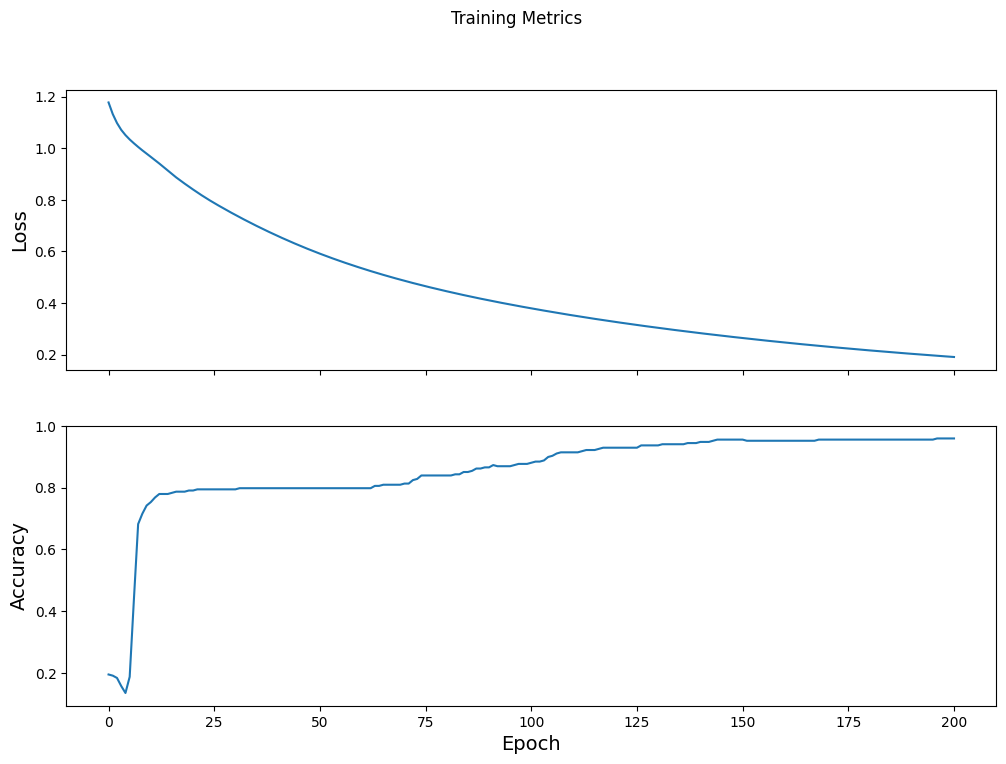

In [19]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## 评估模型的效果

现在已经对模型进行了训练，您可以获得一些有关其性能的统计信息。

*评估* 指的是确定模型做出预测的效果。要确定模型在企鹅分类方面的效果，请将一些测量值传递给模型，并要求模型预测它们所代表的企鹅物种。然后，将模型的预测结果与实际标签进行比较。例如，如果模型对一半输入样本的物种预测正确，则[*准确率*](https://developers.google.com/machine-learning/glossary/#accuracy) 为 <code>0.5</code>。图 4 显示的是一个效果更好一些的模型，该模型做出 5 次预测，其中有 4 次正确，准确率为 80%：

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4">
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">样本特征</th>
    <th colspan="1">标签</th>
    <th colspan="1">模型预测</th>
  </tr>
  <tr>
    <td>5.9</td>
<td>3.0</td>
<td>4.3</td>
<td>1.5</td>
<td align="center">1</td>
<td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td>
<td>3.1</td>
<td>5.4</td>
<td>2.1</td>
<td align="center">2</td>
<td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td>
<td>3.3</td>
<td>1.7</td>
<td>0.5</td>
<td align="center">0</td>
<td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td>
<td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td>
<td>2.5</td>
<td>4.0</td>
<td>1.3</td>
<td align="center">1</td>
<td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">     <b>图 4</b>. 一个准确率为 80% 的企鹅分类器。<br>
</td></tr>
</table>

### 设置测试集

评估模型与训练模型相似。最大的区别在于，样本来自一个单独的[测试集](https://developers.google.com/machine-learning/crash-course/glossary#test_set)，而不是训练集。为了公正地评估模型的效果，用于评估模型的样本务必与用于训练模型的样本不同。

企鹅数据集不具备单独的测试数据集，因此在上方的“下载数据集”部分中，您已将原始数据集拆分为测试数据集和训练数据集。使用 `ds_test_batch` 数据集进行评估。

### 根据测试数据集评估模型

与训练阶段不同，模型仅评估单个[周期](https://developers.google.com/machine-learning/glossary/#epoch)的测试数据。以下代码会对测试集中的每个样本进行迭代，并将模型的预测与实际标签进行比较。这是为了衡量模型在整个测试集上的准确率：

In [20]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 97.015%


您还可以使用 `model.evaluate(ds_test, return_dict=True)` Keras 函数来基于您的测试数据集获取准确率信息。 

例如，通过检查最后一个批次，您可以观察到模型预测通常正确。


In [21]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(7, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [0, 0]])>

## 使用经过训练的模型进行预测

您已经训练了一个模型，并证明了该模型在对企鹅物种进行分类方面做的不错（但不完美）。现在，我们使用训练后的模型对[*无标签样本*](https://developers.google.com/machine-learning/glossary/#unlabeled_example)（即包含特征但不包含标签的样本）进行一些预测。

在现实生活中，无标签样本可能来自许多不同的源（包括应用、CSV 文件和数据馈送）。在本教程中，手动提供三个无标签样本来预测它们的标签。回顾一下标签编号与命名表示之间的映射关系：

- `0`：阿德利企鹅
- `1`：帽带企鹅
- `2`：金图企鹅

In [22]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Adélie (87.2%)
Example 1 prediction: Gentoo (96.2%)
Example 2 prediction: Chinstrap (82.3%)
